# PIT - Práctica 3: Detección de Actividad de Voz (VAD)

**Alicia Lozano Díez**

11 de marzo de 2024


**Lucas Juez Stapleton**

**Alvaro Alvarez**

## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento de señales temporales de voz, y desarrollar de un detector de actividad de voz basado en redes neuronales recurrentes, en particular, LSTM.

### Materiales

- Guión (.ipynb) de la práctica - Moodle
- Ejemplos de datos y etiquetas - Moodle
- Listas de entrenamiento y validación - Moodle
- Scripts de descarga de datos - Moodle
- Datos y etiquetas de entrenamiento * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EdCueYU7BpNAuo6BawH8hJAB5rclap745BmsPzXgSPhsgw?e=VmkzaU)
- Datos y etiquetas de validación * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EWBjWyX774pLhJc2ahr4zk0BtLvWt7YGhdMDDmGu-LcBNQ?e=n2cHs5)


**CUIDADO: * Los datos proporcionados son de uso exclusivo para esta práctica. No tiene permiso para copiar, distribuir o utilizar el corpus para ningún otro propósito.**


# 1. Introducción al procesamiento de señales temporales de voz

## 1.1. Descarga de ficheros de ejemplo

Primero vamos a descargar el audio de ejemplo de Moodle (**audio_sample.wav**) y ejecutar las siguientes  líneas de código, que nos permitirán subir el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving audio_sample.wav to audio_sample.wav
Saving audio_sample_labels_1.voz to audio_sample_labels_1.voz
Saving audio_sample_labels_2.voz to audio_sample_labels_2.voz
Saving audio_sample_test.mat to audio_sample_test.mat
Saving audio_sample_test.wav to audio_sample_test.wav
Saving data_download_onedrive_training_VAD.sh to data_download_onedrive_training_VAD.sh
Saving data_download_onedrive_valid_VAD.sh to data_download_onedrive_valid_VAD.sh
Saving PR3_PIT.ipynb to PR3_PIT.ipynb
Saving training_VAD.lst to training_VAD.lst
Saving valid_VAD.lst to valid_VAD.lst


Una vez cargado el fichero de audio, podemos escucharlo de la siguiente manera:

In [ ]:
import IPython

wav_file_name = "audio_sample.wav"
print(wav_file_name)
IPython.display.Audio(wav_file_name)

audio_sample.wav


## 1.2. Lectura y representación de audio en Python

A continuación vamos a definir ciertas funciones para poder hacer manejo de  ficheros de audio en Python.

Comenzamos definiendo una función **read_recording** que leerá un fichero de audio WAV, normalizará la amplitud y devolverá el vector de muestras _signal_ y su frecuencia de muestreo _fs_.

In [ ]:
import scipy.io.wavfile

def read_recording(wav_file_name):
  fs, signal = scipy.io.wavfile.read(wav_file_name)
  signal = signal/max(abs(signal)) # normalizes amplitude

  return fs, signal


Si ejecutamos la función anterior para el fichero de ejemplo, podemos ver la forma en la que se carga dicho fichero de audio en Python. Así, podemos obtener la frecuencia de muestreo y la longitud del fichero en número de muestras:

In [ ]:
fs, signal = read_recording(wav_file_name)
print("Signal variable shape: " + str(signal.shape))
print("Sample rate: " + str(fs))
print("File length: " + str(len(signal)) + " samples")


Signal variable shape: (67072,)
Sample rate: 16000
File length: 67072 samples


**PREGUNTAS:**

- ¿Como obtendría la duración de la señal en segundos?

Sabiendo que la frecuencia de muestreo es el tiempo entre cada toma de muestras, por lo que, si $D$ es la duración, $f_s$ es la frecuencia de muestreo (que `scipy` nos devuelve en muestras por segundo) y tenemos $n$ muestras, entonces
$$
D = \frac{n}{f_s} = \frac{67072}{16000} = 4.192 \text{ segundos}
$$

Lo cual coincide con lo representado en la celda anterior al punto 1.2.

También podemos representar la señal y ver su forma de onda. Para ello, definimos la función **plot_signal** como sigue:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal(signal, fs, ylabel="", title="", label=""):
  dur = len(signal)/fs
  step = 1./fs
  t_axis = np.arange(0., dur, step)

  plt.plot(t_axis, signal, label = label)
  plt.xlim([0, dur])
  plt.ylabel(ylabel)
  plt.xlabel('Time (seconds)')
  plt.title(title)
  plt.grid(True)


Y utilizando la función anterior, obtenemos su representación (amplitud frente al tiempo):

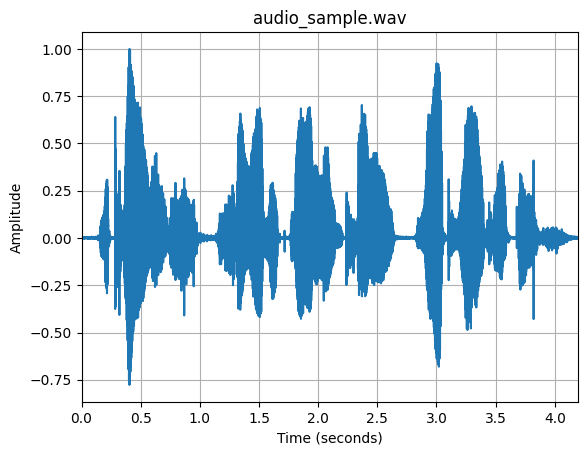

In [ ]:
plot_signal(signal, fs, "Amplitude", wav_file_name)
plt.show()

**PREGUNTAS:**
- Incluya en el informe la representación obtenida.

## 1.3. Representación de etiquetas de actividad de voz

En esta práctica, vamos a desarrollar un detector de actividad de voz, que determinará qué segmentos de la señal de voz son realmente voz y cuáles silencio.

Por ello, vamos a ver dos ejemplos de etiquetas _ground truth_, que corresponden al fichero de audio de ejemplo.

Primero, descargamos de Moodle las etiquetas de voz/silencio que están en los ficheros **audio_sample_labels_1.voz** y **audio_sample_labels_2.voz** y las cargamos en Google Colab como en el caso anterior.

In [ ]:
from google.colab import files
uploaded = files.upload()

Estas etiquetas están guardadas en ficheros de texto y podemos cargarlas en Python de la siguiente manera:

In [ ]:
labels_file_name = 'audio_sample_labels_1.voz'
voice_labels = np.loadtxt(labels_file_name)


Con el siguiente código, podemos representar la señal de voz así como sus etiquetas en la misma figura:

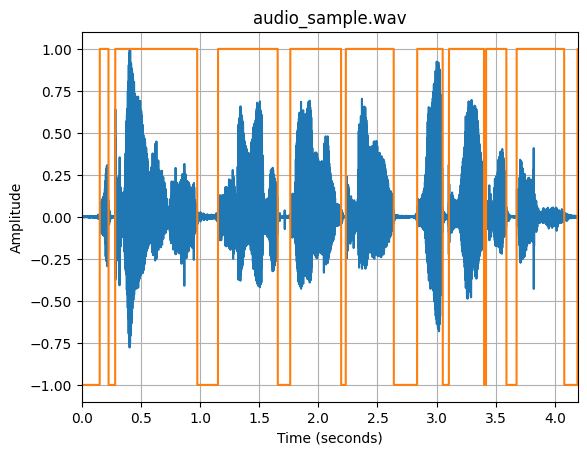

In [ ]:
plot_signal(signal, fs)
plot_signal(voice_labels*2-1, fs, "Amplitude", wav_file_name)
plt.show()

In [ ]:
labels_file_name_2 = 'audio_sample_labels_2.voz'
voice_labels_2 = np.loadtxt(labels_file_name_2)

Las etiquetas de voz/silencio provienen de distintos detectores de actividad de voz.

**PREGUNTAS:**
- ¿Qué valores tienen las etiquetas? ¿Qué significan dichos valores?

Vemos que las etiquetas tienen valores $\{-1,1\}$. Esto tiene bastante sentido, pues lo que queremos representar es si alguien está hablando (representado por un $1$), o si no hay nadie hablando (representado por un $-1$).

- ¿Por qué se representa _voice_labels*2-1_?

Esto se hace porque en el fichero tenemos valores $1$ y $0$, y nos interesa que las partes en las que no haya nadie hablando se les de la etiqueta $-1$. Por lo que multiplicamos por dos para que haya valores 2 y 0, y asi poder obtener 1 y -1 al restar 1 a 2 y 0 respectivamente.

- Represente la señal de voz junto con las etiquetas para ambos casos e incluya las figuras en el informe de la práctica. ¿Qué diferencias observas? ¿A qué se puede deber?

Puesto que hemos modificado la función de dibujado para añadir las etiquetas, podemos dibujar ambos etiquetados sobre la misma figura.



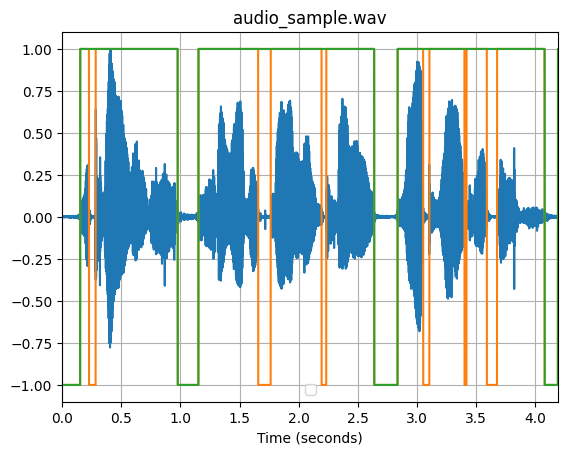

In [ ]:
plot_signal(signal, fs, label = "Original signal")
plot_signal(voice_labels*2-1, fs, "Amplitude", wav_file_name, label="First labels")# Label 1, cuando se ejecutaba no funcionaba el label, si se vuelve a ejecutar deveria
plot_signal(voice_labels_2*2-1,fs,"", wav_file_name, label="Second labels")
_ = plt.legend()
_ = plt.plot()

Las diferencias son que el naranja (etiqueta 1) tiende a ser mas preciso, ya que representa las pequeñas pausas de habla entre palabras que se interumpen/frases que se dicen muy rapido pero hay un pequeño paron de no voz, al igual que el espacio mas grande entre la secuencia de ruido de voz, mientras que en el segundo solo muestra el paron de voz grande entre las secuencias de palabras (la segunda secuencia mencionada).

 Estas diferencias pueden deberse a diferentes factores. Podemos hacer una enumeración de algunos ejemplos:

1. La frecuencia de muestreo de ambos detectores de actividad es diferente
2. El umbral a partir del cual los detectores indican que está habiendo una voz/sonido es diferente
3. La precisión de estos detectores no es la misma (uno es más preciso que el otro).

Si la celda anterior se ejecuta de nuevo, saldrá con las etiquetas en la leyenda.


- ¿Qué cantidad de voz/silencio hay en cada etiquetado?

Para esto, tenemos que contar el número de etiquetas de cada tipo de alguna manera y entonces calcular la duración a partir de la frecuencia de muestreo igual que lo hacíamos en un apartado anterior. Definimos una función que nos lo calcule:

In [ ]:
def voice_silence_quantity(labels, f_s):
  count_voice = np.count_nonzero(labels)

  print("Voice time: {} seconds".format(count_voice/fs))
  print("Silent time: {} seconds".format( (len(labels)-count_voice)/fs))

print("First labels")
voice_silence_quantity(voice_labels,fs)
print("Second labels")
voice_silence_quantity(voice_labels_2,fs)

First labels
Voice time: 3.1969375 seconds
Silent time: 0.9950625 seconds
Second labels
Voice time: 3.5544375 seconds
Silent time: 0.6375625 seconds


Podemos observar como, según el segundo detector de audio, tenemos más tiempo hablando y menos tiempo en silencio que en el primero.

## 1.4. Extracción de características

En la mayoría de sistemas de reconocimiento de patrones, un primer paso es la extracción de características. Esto consiste, a grandes rasgos, en obtener una representación de los datos de entrada, que serán utilizados para un posterior modelado.

En nuestro caso, vamos pasar de la señal en crudo _"raw"_ dada por las muestras (_signal_), a una secuencia de vectores de características que extraigan información a corto plazo de la misma y la representen. Esta sería la entrada a nuestro sistema de detección de voz basado en redes neuronales.

Para ver algunos ejemplos, vamos a utilizar la librería _librosa_ (https://librosa.org/doc/latest/index.html).

Dentro de esta librería, tenemos funciones para extraer distintos tipos de características de la señal de voz, como por ejemplo el espectrograma en escala Mel (_melspectrogram_).

Estas características a corto plazo, se extraen en ventanas de unos pocos milisegundos con o sin solapamiento.

Un ejemplo sería el siguiente:


In [ ]:
import librosa

mel_spec = librosa.feature.melspectrogram(y=signal,sr=fs,n_mels=23,win_length=320,hop_length=160)

print(mel_spec.shape)
print(signal.shape)

(23, 420)
(67072,)


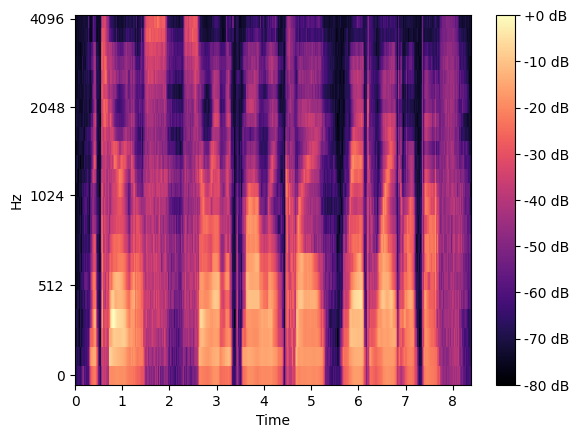

In [ ]:
from librosa.display import specshow

S_DB = librosa.power_to_db(mel_spec, ref=np.max)
specshow(S_DB, sr=fs, hop_length=160, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

**PREGUNTAS:**
- ¿Qué se obtiene de la función anterior?

Obtenemos la representación del melespectrograma extraído de la señal, que mide la amplitud de la señal en una malla de frecuencia (en escala Mel) y tiempos discretizados (frames).

En otras palabras.
Al ejecutar la función anterior obtenemos el **espectrograma en escala de Mel**. La escala habitual de las señales es la *frecuencia*. Para obtener una señal en escala de Mel tenemos que hacer la transformación de la frecuencia habitual $f$ a Mels $m$. Una fórmula habitual para hacer esto es
$$
m=2595\log _{10}\left(1+{\frac {f}{700}}\right)
$$

- ¿Qué significan los valores de los parámetros _win_length_ y _hop_length_?

1. El `win_length` es el tamaño de la ventana usado para el enventanado de la señal de audio. Si el tamaño de la ventana no llega al tamaño de ventana usado para calcular la FFT de la señal (parámetro `n_fft`), se rellena con ceros hasta llegar a este tamaño. Esto es porque es más óptimo estimar la FFT usando un número de puntos que sea potencia de dos.

2. El `hop_length` es el número de elementos que se dejan entre ventanas sucesivas. Si tomásemos por ejemplo `hop_length = win_length`, entonces tendríamos ventanas sin solapar.

Es decir, el parámetro `win_length = 320` representa el tamaño de ventana que se utiliza para aplicar la transformada de Fourier en cada frame de audio (si es distinto de n_fft se completa con 0s hasta que coincida). Por su parte, el parámetro `hop_length = 160` controla el número de samples que hay entre dos frames consecutivos, algo así como el “salto” entre ventanas. Notamos que el número de frames (instantes de tiempo en la malla) que obtenemos al final se calcula a partir de este parámetro como

$$\frac{67072 \text{samples}}{160 \text{samples/frames}} = 419.2 ≈ 420\text{ frames}$$

- ¿Qué dimensiones de _mel_spec_ obtienes? ¿Qué significan?


Vemos que hemos obtenido unas dimensiones de $23 \times 420$ en el espectrograma. Este $23$ es el número de mels (*features* generadas) que le hemos indicado como parámetro, y $420$ es el número de ventanas totales que hemos necesitado. Este número se calcula como el cociente entre el tamaño total de la señal y la distancia entre inicios de ventana (`hop_length`). En resumidas cuentas obtenemos una matriz de tamaño 23 × 420, donde las filas representan cada una
de las 23 divisiones equiespaciadas en las que se ha discretizado la escala Mel, y las columnas cada
uno de los instantes de tiempo considerados.

In [ ]:
hop_length = 160
print(mel_spec.shape[1] * hop_length )
print(signal.shape)

67200
(67072,)


Vemos que hemos obtenido una pequeña diferencia, que ha ocurrido porque para la última ventana tenemos menos elementos en la señal que el tamaño de la ventana. Lo que se suele hacer en estos casos es añadir *zero padding* o recortar esta última ventana.

De esta manera, podríamos obtener una parametrización de las señales para ser utilizadas como entrada a nuestra red neuronal.

Para los siguientes apartados, se proporcionan los vectores de características MFCC para una serie de audios que se utilizarán como conjunto de entrenamiento del modelo de VAD.

#2. Detector de actividad de voz (Voice Activity Detector, VAD)



## 2.1. Descarga de los datos de entrenamiento

Primero vamos a descargar la lista de identificadores de los datos de entrenamiento de la práctica.

Para ello, necesitaremos descargar de Moodle el fichero **training_VAD.lst**, y ejecutar las siguientes líneas de código, que nos permitirán cargar el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

A continuación cargamos los identificadores contenidos en el fichero en una lista en Python:

In [ ]:
file_train_list = 'training_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
f.close()

Podemos ver algunos de ellos (los primeros 10 identificatores) de la siguiente forma:

In [ ]:
print(train_list[:10])

['features_labs_1.mat', 'features_labs_10.mat', 'features_labs_100.mat', 'features_labs_101.mat', 'features_labs_102.mat', 'features_labs_103.mat', 'features_labs_104.mat', 'features_labs_105.mat', 'features_labs_106.mat', 'features_labs_107.mat']


Ahora, descargaremos de Moodle el fichero **data_download_onedrive_training_VAD.sh**, y ejecutaremos las siguientes líneas de código, que nos permitirán cargar el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Para descargar el conjunto de datos desde One drive, ejecutamos el script cargado anteriormente de la siguiente manera:

In [ ]:
!chmod 755 data_download_onedrive_training_VAD.sh
!./data_download_onedrive_training_VAD.sh

--2024-03-12 12:04:24--  https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EdCueYU7BpNAuo6BawH8hJAB5rclap745BmsPzXgSPhsgw?download=1
Resolving dauam-my.sharepoint.com (dauam-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to dauam-my.sharepoint.com (dauam-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/alicia_lozano_uam_es/Documents/PIT/training_VAD.zip?ga=1 [following]
--2024-03-12 12:04:25--  https://dauam-my.sharepoint.com/personal/alicia_lozano_uam_es/Documents/PIT/training_VAD.zip?ga=1
Reusing existing connection to dauam-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 3638232935 (3.4G) [application/x-zip-compressed]
Saving to: ‘EdCueYU7BpNAuo6BawH8hJAB5rclap745BmsPzXgSPhsgw?download=1’

EdCueYU7BpNAuo6BawH 100%[===================>]   3.39G  56.7MB/s    in 71s     

2024-03-12 12:05:37 (48.7 MB/s) - ‘EdCueYU7BpNAuo6BawH8hJA

Este script descargará los datos de One Drive y los cargará en Google Colab, descomprimiéndolos en la carpeta **data/training_VAD**.

Podemos comprobar que los ficheros **.mat** se encuentran en el directorio esperado:


In [ ]:
!ls data/training_VAD/ | head

features_labs_100.mat
features_labs_101.mat
features_labs_102.mat
features_labs_103.mat
features_labs_104.mat
features_labs_105.mat
features_labs_106.mat
features_labs_107.mat
features_labs_108.mat
features_labs_109.mat


## 2.2. Definición del modelo

Utilizando la librería Pytorch (https://pytorch.org/docs/stable/index.html), vamos a definir un modelo de ejemplo con una capa LSTM y una capa de salida. La capa de salida estará formada por una única neurona. La salida indicará la probabilidad de voz/silencio utilizando una función *sigmoid*.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model_1(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_1, self).__init__()

        self.lstm = nn.LSTM(feat_dim,256,batch_first=True,bidirectional=False)
        self.output = nn.Linear(256,1)

    def forward(self, x):

        out = self.lstm(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

**PREGUNTAS:**
- ¿Qué tamaño tiene la entrada a la capa LSTM?

El atributo `self.lstm` contiene una LSTM definida por `pytorch`. Le damos nombre a las variables según la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) de las LSTM de pytorch. Según esta documentación, la **entrada** tiene un tamaño `feat_dim`, que hemos puesto por defecto a $20$.

- ¿Cuántas unidades (celdas) tiene dicha capa LSTM?

Es el parámetro `hidden_size`, en nuestro caso es $256$.

- ¿Qué tipo de matriz espera la LSTM? Mirar la documentación y describir brevemente.

Vamos a llamar $N$ al batch size, $L$ a la longitud de una secuencia y $H_{in}$ al tamaño de entrada (`input_size`). Entonces,la LSTM espera un **tensor** de dimensiones $(L,N,H_{in})$ cuando el parámetro `batch_first = False` y un tensor de dimensiones $(N,L,H_{in})$ cuando el parámetro `batch_first = True`. Podrían ser varaibles con longitud variable, pero tendríamos que cambiar otros parámetros.

Este tensor es obligatorio, pero también se le puede pasar adicionalmente $(h_0,c_0)$ siendo $h_0$ los estados ocultos iniciales para cada elemento del batch y $c_0$ el estado de la celda inicial para cada elemento del batch.

Otra forma de explicarlo es: La LSTM espera como entrada una matriz de dimensiones (batch, seq, feature), donde batch es el tamaño de batch (conjunto de segmentos), seq el número de frames de cada segmento,
y feature el tamaño de la entrada (número de características por cada frame). En nuestro caso, pasaremos tensores de entrada de tamaño (51, 300, 20) (teniendo como referencia los datos del codigo de entrenamiento). Además, aunque nosotros no lo hacemos, se puede pasar también el estado inicial de las celdas y los estados ocultos para cada elemento del batch, que por defecto se inicializan a 0.


- Revisar la documentación de _torch.nn.LSTM_ y describir brevemente los argumentos _batch_first_, _bidirectional_ y _dropout_.

El parámetro `batch_first` hace referencia a cómo tiene que interpretar la LSTM los *tensores* que le damos como entrada. La interpretación que hace es la que hemos indicado en la pregunta anterior. El valor por defecto es `False`.

El parámetro `bidirectional` indica si la LSTM será o no bidireccional.

El parámetro `dropout` es el parámetro estándar de dropout de las redes neuronales. Este parámetro indica si vamos a *matar* neuronas para que dejen de entrenarse con una probabilidad $p$.

- En este modelo, estamos utilizando una única neurona a la salida. ¿Hay alguna otra alternativa? ¿Se seguiría utilizando una función _sigmoid_?

Tenemos un vector de tamaño $256$ como entrada a esta neurona. Podríamos aplicar una nueva **red neuronal** a estas características para posiblemente seleccionar aún más las características extraídas por la LSTM. En este caso, al final de esta nueva red neuronal, se volvería a usar una función sigmoidal, pues nos da una probabilidad de pertenecer a una clase.

- ¿Para qué sirve la función _forward_ definida en la clase _Model_1_?

Esta función define qué proceso sigue una entrada $x$ cuando se le pasa a la red. En nuestro caso, primero se le aplica la LSTM, luego la neurona única y por último la función de activación.

Una vez definida la clase, podemos crear nuestra instancia del modelo y cargarlo en la GPU con el siguiente código:

In [ ]:
model = Model_1(feat_dim=20)
model = model.to(torch.device("cpu"))
print(model)

Model_1(
  (lstm): LSTM(20, 256, batch_first=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
)


Nuestra variable _model_ contiene el modelo, y ya estamos listos para entrenarlo y evaluarlo.

##2.3. Lectura y preparación de los datos para el entrenamiento

Como hemos visto anteriormente, nuestros datos están guardados en ficheros de Matlab (**.mat**). Cada uno de estos ficheros contiene una matriz **X** correspondiente a las secuencias de características MFCC (con sus derivadas de primer y segundo orden), y un vector **Y** con las etiquetas de voz/silencio correspondientes.

Veamos un ejemplo:


In [ ]:
features_file = 'data/training_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file)['X']
labels = scipy.io.loadmat(features_file)['Y']

print(features.shape)
print(labels.shape)


(46654, 60)
(46654, 1)


**PREGUNTAS:**
Elegir un fichero de entrenamiento y responder a las siguientes preguntas:
- ¿Qué tamaño tiene **features**? ¿Y **labels**?
- Una de las dimensiones de la **features** es 60, correspondiente a los 20 coeficientes MFCC concatenados con las derivadas de primer y segundo orden. ¿Con qué se corresponde la otra dimensión?

Podemos responder a las dos preguntas conjuntamente:

Vemos que las dimensiones de las features es $(46654, 60)$, mientras que la de las etiquetas es $(46654, 1)$. Sabemos que siempre tenemos que tener para cada elemento del conjunto de entrenamiento una etiqueta. Por ello, tenemos que $46654$ es el número de ejemplos de entrenamiento que tenemos, y es a este número de ejemplos de entrenamiento a lo que corresponde esa primera dimensión.

El entrenamiento del modelo se va a realizar mediante descenso por gradiente (o alguna de sus variantes) basado en _batches_.

Para preparar cada uno de estos _batches_ que servirán de entrada a nuestro modelo LSTM, debemos almacenar las características en secuencias de la misma longitud. El siguiente código lee las características (**get_fea**) y sus correspondientes etiquetas (**get_lab**) de un fragmento aleatorio del fichero de entrada.

In [ ]:
import scipy.io
import numpy as np

def get_fea(segment, rand_idx):
    data = scipy.io.loadmat(segment)['X']
    if data.shape[0] <= length_segments:
        start_frame = 0
    else:
        start_frame = np.random.permutation(data.shape[0]-length_segments)[0]

    end_frame = np.min((start_frame + length_segments,data.shape[0]))
    rand_idx[segment] = start_frame
    feat = data[start_frame:end_frame,:20] # discard D and DD, just 20 MFCCs
    return feat[np.newaxis, :, :]


def get_lab(segment, rand_idx):
    data = scipy.io.loadmat(segment)['Y']
    start_frame = rand_idx[segment]
    end_frame = np.min((start_frame + length_segments, data.shape[0]))
    labs = data[start_frame:end_frame].flatten()
    return labs[np.newaxis,:]

**PREGUNTAS:**
Analizar las funciones anteriores detenidamente y responder a las siguientes cuestiones:

un análisis detallado de las dos funciones proporcionadas:

1) `get_fea(segment, rand_idx)`:

`segment`: Es el nombre del segmento del cual se cargarán las características.

`rand_idx`: Es un diccionario que se utiliza para realizar un seguimiento de los índices aleatorios seleccionados para cada segmento.

`data = scipy.io.loadmat(segment)['X']`: Carga las características del archivo mat correspondiente al segmento.

Verifica si la longitud de data es menor o igual a `length_segments`. Si es así, `start_frame` se establece en 0; de lo contrario, se elige un índice aleatorio dentro del rango válido.

`end_frame` se calcula como el mínimo entre `start_frame + length_segments` y la longitud total de data.

Se actualiza rand_idx con el valor de `start_frame`.

Selecciona las primeras 20 columnas (MFCCs) de las características y devuelve el resultado como un tensor tridimensional con forma (1, length_segments, 20).

2) `get_lab(segment, rand_idx)`:

`segment`: Es el nombre del segmento del cual se cargarán las etiquetas.

`rand_idx`: Es un diccionario que contiene los índices aleatorios seleccionados previamente para cada segmento.

`data = scipy.io.loadmat(segment)['Y']`: Carga las etiquetas del archivo mat correspondiente al segmento.

`start_frame` se obtiene de `rand_idx[segment]`.

`end_frame` se calcula de manera similar a `get_fea`.

Las etiquetas se obtienen aplanando el segmento de etiquetas entre `start_frame` y `end_frame`.

El resultado se devuelve como un tensor unidimensional.

- ¿De qué tamaño son los fragmentos que se están leyendo?

Vemos que los fragmentos se están tomando de tamaño `length_segments`, que estaba definido más abajo en el código. Lo hemos cambiado añadiéndolo a la celda de código anterior para mayor entendimiento del mismo.

- ¿Para qué sirve _rand_idx_?

Esta variable es un diccionario que mantiene en qué posición se ha empezado a tomar las `features` en cada iteración, y sirve para que tomemos bien las etiquetas del conjunto de etiquetas, es decir, para que tomemos correctamente la etiqueta correspondientes a cada muestra.

## 2.4. Entrenamiento del modelo
Una vez definidas las funciones de lectura de datos y preparación del formato que necesitamos para la entrada a la red LSTM, podemos utilizar el siguiente código para entrenarlo.

In [ ]:
length_segments = 300
path_in_feat = 'data/training_VAD/'

from torch import optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 51
segment_sets = np.array_split(train_list, len(train_list)/batch_size)

accs, losses = [], []

max_iters = 5
for epoch in range(1, max_iters):
  print('Epoch:', epoch)

  model.train()
  cache_loss = 0
  y_pred, y_true = [], []

  for ii, segment_set in enumerate(segment_sets):
    rand_idx = {}
    optimizer.zero_grad()

    # Create training batches
    train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
    labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16) for segment in segment_set])
    assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label

    # Shuffle the data and place them into Pytorch tensors
    shuffle = np.random.permutation(len(labs_batch))
    labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))
    train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))

    #print(f"  Mini-batch {ii+1}")

    # Forward the data through the network
    outputs = model(train_batch)

    # Compute cost
    loss = criterion(outputs, labs_batch)

    # Backward step
    loss.backward()
    optimizer.step()
    cache_loss += loss.item()

    # Save
    preds = outputs.cpu().detach().numpy().flatten()
    y_pred.extend([1 if p >= 0.5 else 0 for p in preds])
    y_true.extend(labs_batch.cpu().numpy().flatten())
  # Calculo final de los loss y accuracy finales
  y_pred = np.array(y_pred, dtype=np.float32)
  y_true = np.array(y_true, dtype=np.float32)
  acc = np.mean(y_true == y_pred)
  loss = cache_loss/(ii+1)

  print(f"  Loss: {loss:.5f}")
  print(f"  Accuracy: {acc:.3f}")

  accs.append(acc)
  losses.append(loss)

Epoch: 1
  Loss: 0.61073
  Accuracy: 0.696
Epoch: 2
  Loss: 0.44966
  Accuracy: 0.803
Epoch: 3
  Loss: 0.33261
  Accuracy: 0.856
Epoch: 4
  Loss: 0.30724
  Accuracy: 0.882


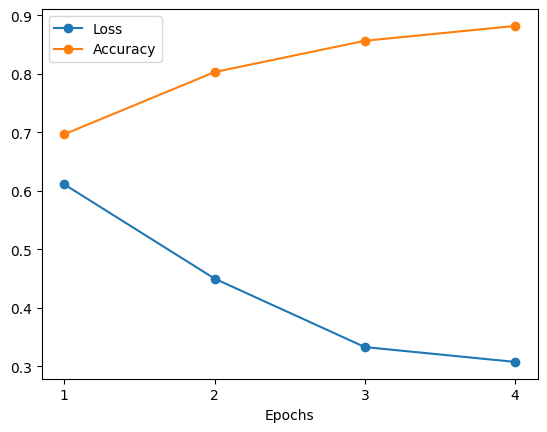

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(max_iters - 1) + 1
plt.plot(epochs, losses, "-o", label="Loss")
plt.plot(epochs, accs, "-o", label ="Accuracy")
plt.xticks(epochs)
plt.xlabel("Epochs")
plt.legend()
plt.show()

**PREGUNTAS:**
Analizar el código anterior cuidadosamente y ejecutarlo. A continuación, responder a las siguientes cuestiones:

Análisis del codigo:

1) Configuración inicial:

`length_segments = 300`: Define la longitud de los segmentos.

`path_in_feat = 'data/training_VAD/'`: Especifica la ruta de las características de entrada.

2) Configuración del modelo y optimizador:

`criterion = nn.BCELoss()`: Define la función de pérdida, que en este caso es la pérdida de entropía cruzada binaria (BCE).

`optimizer = optim.Adam(model.parameters(), lr=0.001)`: Utiliza el optimizador Adam con una tasa de aprendizaje de 0.001.

3) Configuración del lote y divisiones de datos:

`batch_size = 51`: Define el tamaño del lote para el entrenamiento.

`segment_sets = np.array_split(train_list, len(train_list)/batch_size)`: Divide la lista de entrenamiento en conjuntos de segmentos para formar lotes.

4) Bucle principal de entrenamiento:

`max_iters = 5`: Define el número máximo de épocas.

El bucle `for epoch in range(1, max_iters)`: itera sobre las épocas de entrenamiento.

`model.train()`: Establece el modelo en modo de entrenamiento.

Inicializa variables para el seguimiento de la pérdida (`cache_loss`) y las predicciones (`y_pred, y_true`).

Itera sobre los lotes de datos (`for ii, segment_set in enumerate(segment_sets):`).

Se obtienen lotes de características (`train_batch`) y etiquetas (`labs_batch`) mediante la función get_fea y `get_lab`.

Se realiza la mezcla aleatoria de los datos.

Las matrices de Numpy se convierten en tensores de PyTorch y se envían al dispositivo CPU.

Se realiza la propagación hacia adelante (`outputs = model(train_batch)`).
Se calcula la pérdida usando la función de pérdida definida (`loss = criterion(outputs, labs_batch)`).

Se realiza la retropropagación (`loss.backward()`) y se actualizan los pesos del modelo (`optimizer.step()`).

Se acumula la pérdida en `cache_loss`.



Después de cada época, se calcula la precisión y la pérdida promedio:

`y_pred` y `y_true` se convierten en matrices Numpy y se calcula la precisión.

La pérdida promedio se calcula dividiendo `cache_loss` por el número total de lotes.

Finalmente, se imprimen y registran la pérdida y la precisión para cada época.

En resumen, este código implementa un bucle de entrenamiento para un modelo de clasificación binaria utilizando PyTorch, Adam como optimizador y BCELoss como función de pérdida. Además, realiza la división de los datos en lotes y realiza la retropropagación para ajustar los pesos del modelo durante el entrenamiento.

- **¿Qué función de coste se está optimizando? Describir brevemente con ayuda de la documentación.**

Vemos que se está utilizando `nn.BCELoss()`. Mirando la documentación, vemos que esta función nos devuelve la **Entropía Cruzada Binarizada**. Vamos a definir esta entropía. Consideramos el logaritmo de la verosimilitud en un problema de clasificación binaria:

$$
l_n = -w_n \left[ y_n \cdot \log x_n  + (1-y_n)\cdot \log (1- x_n)\right].
$$

entonces, si $L = \{l_1,\dots, l_N\}^T$, donde $N$ es el tamaño de batch la Entropía cruzada binarizada es

$$
l(x,y) = \begin{cases} mean(L), & \text{ if reduction} = \text{'mean'} \\
sum(L) & \text{ if reduction} = \text{'sum'}
\end{cases}
$$

donde 'mean' y 'sum' se le pueden pasar como parámetro a la función `BCELoss`.

- **¿Qué optimizador se ha definido?**

Se ha definido como optimizador `Adam`, con un `learning_rate = 0.001` (que es un valor común en redes neuronales). Se trata de un método de descenso por gradiente estocástico que actúa sobre los batches de datos, basado en una estimación adaptable de los momentos de primer y segundo orden.

- **¿Para qué se utiliza _batch_size_?**

El entrenamiento no se realiza utilizando en cada iteración todos los ejemplos del conjunto de entrenamiento, sino que se toma un subconjunto de ellos de tamaño `batch_size`. Se calculan los gradientes y la función de pérdida sobre este subconjunto en cada iteración.

- **Describir brevemente la creación de los _batches_.**

Los batches se crean en varias etapas. Para comenzar, se crea un array en el que se divide el conjunto de entrenamiento en `N` subconjuntos (o segmentos), donde $N = \frac{\text{tamaño total}}{\text{batch size}}$.

Entonces, para crear un batch se seleccionan esos $N$ nombres de archivo y se le pasan a la función `get_fea`, que lee esos archivos de disco y selecciona $300$ instantes temporales consecutivos comenzando en una posición aleatoria. Para esos instantes temporales, nos quedamos solo con las $20$ primeras características correspondientes a los MFCCs de ese audio. Entonces, hemos conseguido un tensor de dimensiones $(51,300,20)$ que será nuestro batch y es lo que usamos para entrenar nuestro modelo.

- **¿Qué línea de código realiza el _forward pass_?**

Este paso hacia adelante está hecho en la línea que "llama al modelo":
```python
# Forward the data through the network
outputs = model(train_batch)
```
Se obtienen las salidas del modelo, que son usadas para calcular el valor de la función de coste en el batch usado y luego realizar el backward pass.


- **¿Qué línea de código realiza el _backward pass_?**

Se realiza después de calcular el valor de la función de pérdida con ese batch:

```python
# Backward step
loss.backward()
```

- **¿Cuántas iteraciones del algoritmo ha realizado? ¿Qué observa en la evolución de la función de coste?**

Vemos que se han realizado `epochs - 1` iteraciones o épocas (pues empezamos desde la época 1 el bucle de entrenamiento.  En este caso, han sido 4 épocas.

La evolución de la función de pérdida la vemos en una gráfica un poco más adelante.


- **Añada al código el cálculo de la precisión o _accuracy_, de tal manera que se muestre por pantalla dicho valor en cada iteración (similar a lo que ocurre con el valor del coste _loss_). Copiar el código en el informe y describir brevemente.**


Escribimos código para añadir el cómputo del accuracy. Este código no es directo, pues como estamos entrenando con la GPU, lo primero que debemos hacer es pasar los array a la CPU para poder luego hacer los cálculos de manera sencilla.  Lo hacemos en los siguientes pasos:

Primero, creamos dos vectores para añadir todas las predicciones para un batch `y_true, y_pred`. A continuación, entrenamos el modelo y obtenemos el output del mismo. Este output nos indica la probabilidad de pertenecer a la clase $1$, es decir, de que alguien esté hablando en ese momento. Iteramos segmento a segmento, obteniendo $300$ predicciones por Obtenemos en cada paso $\text{batch}\_\text{size} \times \text{segment}\_\text{size} = 51 \times 300$ predicciones. Tenemos que pasarlas a primero a la CPU y luego a un único vector, para hacer la comparación con las etiquetas reales usando `numpy`.

```python
outputs_numpy = outputs.cpu().detach().numpy().flatten()
y_pred.extend([1 if p >= 0.5 else 0 for p in outputs_numpy])
y_true.extend( labs_batch.cpu().numpy().flatten())
```

A continuación, calculamos el accuracy usando las etiquetas obtenidas. Así se hizo cuando funcionaba con GPU, con CPU y no GPU, se hace igual sin tener que pasar de GPU a CPU.

**Nota.-** Finalmente,se ha decidido crear una función `predict` a la que se le envía un tensor con las características y esta función pasa el tensor a la *GPU*, predice las etiquetas y las devuelve en formato `numpy`. Esta función usa en esencia el código anterior, salvo que necesita para predecir que el modelo no aprenda en esa pasada de los datos por el mismo, así que hay que establecer el modo del modelo en `model.eval()` (evaluación) y usar `torch.no_grad` para que no se calculen los gradientes.





- **¿Qué valor de coste y _accuracy_ obtiene? ¿Cómo se puede mejorar?**

El coste y accuracy por epoc son Epoch: 1
  Loss: 0.61073
  Accuracy: 0.696
Epoch: 2
  Loss: 0.44966
  Accuracy: 0.803
Epoch: 3
  Loss: 0.33261
  Accuracy: 0.856
Epoch: 4
  Loss: 0.30724
  Accuracy: 0.882 y se pueden apreciar en la tabla que se ha representado.
  
En principio podríamos mejorar estos valores (disminuir el coste y aumentar el accuracy) entrenando durante más épocas, ya que parece que aún no han llegado al punto de saturación de aprendizaje en el cual se estabilizan. Sin embargo, habría que tener cuidado de no entrenar demasiadas épocas y caer en overfitting, o de lo contrario estas mejoras no se verían reflejadas en las predicciones sobre señales que no han sido vistas antes por el modelo.

## 2.5. Evaluación del modelo: un único fichero de test

Una vez entrenado el modelo, vamos a evaluarlo en un ejemplo en concreto.

Descargue de Moodle el fichero **audio_sample_test.wav**, con sus correspondientes características y etiquetas **audio_sample_test.mat** y evalúe el rendimiento en el mismo.


In [ ]:
features_file = 'audio_sample_test.mat'

import scipy.io
features = scipy.io.loadmat(features_file)['X'][:, :20]
labels = scipy.io.loadmat(features_file)['Y'].reshape(-1).astype("float32")

print(features.shape)
print(labels.shape)

(57777, 20)
(57777,)


In [ ]:
def get_predictions(features):
    model.eval()
    with torch.no_grad():
        batch = features[np.newaxis, :, :]
        batch = torch.tensor(batch.astype("float32")).to(torch.device("cpu"))

        # predict probabilities of voice for each frame
        # shape of input is (1, 57777, 20)
        preds = model(batch)

    return preds.cpu().numpy()[0]

In [ ]:
# get predictions
probs = get_predictions(features)

# get the predicted labels from the model's predictions
pred_labels = np.array([1 if p >= 0.5 else 0 for p in probs])

print(pred_labels.shape)
print(labels.shape)

(57777,)
(57777,)


In [ ]:
# Get accuracy
acc = np.mean(labels == pred_labels)

print(f'Accuracy: {acc:.3f}')

Accuracy: 0.902


In [ ]:
# save predictions
np.savez("preds_P1.npz", preds=pred_labels)

In [ ]:
wav_file_name = "audio_sample_test.wav"
fs, signal = read_recording(wav_file_name)
print("Signal shape: " + str(signal.shape))
print("Sample rate: " + str(fs))

Signal shape: (4800160,)
Sample rate: 8000


In [ ]:


segment = 1
n_seconds = 10  # only 10 seconds
n_labels_segment = n_seconds*100  # one label every 10 ms

signal_segment = signal[segment*n_seconds*fs:(segment + 1)*n_seconds*fs]
labels_segment = labels[segment*n_labels_segment:(segment + 1)*n_labels_segment]
pred_labels_segment = pred_labels[segment*n_labels_segment:(segment + 1)*n_labels_segment]

print(f"Número de muestras de los {n_seconds} segundos de la señal:", len(signal_segment))



Número de muestras de los 10 segundos de la señal: 80000


In [ ]:
def plot_labels(labels, color='tab:orange'):
    t = np.arange(n_seconds*segment, (segment + 1)*n_seconds, 1./fs)
    labels_range = np.linspace(segment*n_seconds, (segment + 1)*n_seconds, num=n_labels_segment)

    plt.plot(t, signal_segment)
    plt.plot(labels_range, 2*labels - 1, color=color)

    plt.title(wav_file_name)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xticks(np.arange(n_seconds*segment, (segment + 1)*n_seconds + 2, 2))
    plt.xlim([t[0]-1e-3, t[-1]+1e-3])
    plt.show()

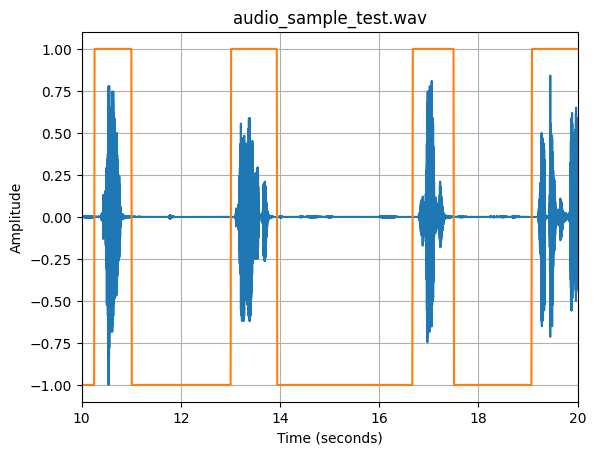

In [ ]:
plot_labels(labels_segment)

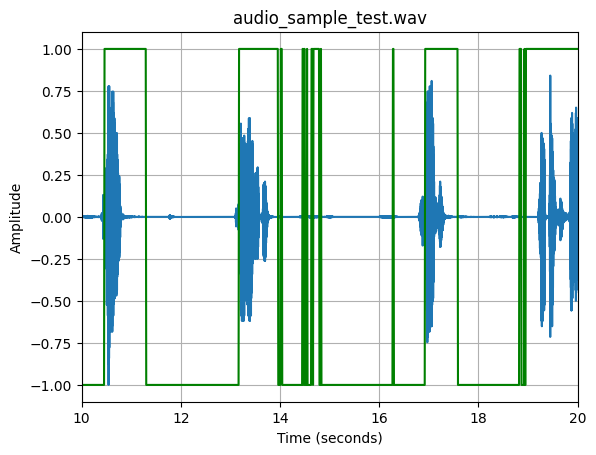

In [ ]:
plot_labels(pred_labels_segment, color="green")

In [ ]:
import IPython

print(wav_file_name)
IPython.display.Audio(wav_file_name)

Output hidden; open in https://colab.research.google.com to view.


**PREGUNTAS:**
- Incluya en el informe de la práctica el código que ha utilizado para evaluar dicho fichero.
- ¿Cuál es el _accuracy_ obtenido para el fichero **audio_sample_test**?

Hemos obtenido un accuracy de 0.902, es decir, del $90.2$

- Represente 10 segundos de dicho audio, así como sus etiquetas de _ground_truth_ y las obtenidas con su modelo. Incluya dicha gráfica en el informe y comente brevemente el resultado. Visualmente, ¿es bueno el modelo?

Vemos que las predicciones son buenas, reproduciendo con éxito las etiquetas de voz/silencio de las que disponemos. Visualmente se aprecia como las predicciones se ajustan mejor a los cambios de silencio a voz (aunque en ocasiones quizás apuran demasiado), mientras que el ajuste de los cambios de voz a silencio es peor, al menos en este segmento de audio. En conjunto, podemos decir que el modelo es bastante bueno.

- Escuche el audio y comente cualitativamente cómo es de bueno o malo el modelo.

Si escuchamos el audio vemos como en los primeros 40 segundos se escucha una persona diciendo una serie de palabras sueltas con bastante silencio entre ellas, cosa que el modelo captura con éxito. Además, se escucha un pequeño ruido de fondo que el modelo acierta en clasificar como silencio, pues no forma parte de la voz. Sin embargo, aunque nuestro modelo es bueno y reproduce (casi) fielmente los segmentos de silencio y voz del audio original, no puede decirse que el problema sea extremadamente difícil (dentro de lo que podría ser), ya que hay una única voz cuyo sonido es alto, y los silencios son en general largos y sin demasiado ruido de fondo.
Parece que el audio es un único lado de una conversación telefónica, y para este tipo de señales (con las características descritas arriba) nuestro modelo sí parece ser bastante bueno.

## 2.6. Evaluación del modelo: conjunto de validación





Ahora vamos a evaluar el rendimiento del modelo anterior sobre un conjunto de validación (del que conocemos sus etiquetas).

Para este conjunto de datos, descargaremos la lista de identificadores **valid_VAD.lst** de Moodle, así como el fichero de descarga de datos **data_download_onedrive_valid_VAD.sh**:

In [ ]:
from google.colab import files
uploaded = files.upload()

!chmod 755 data_download_onedrive_valid_VAD.sh
!./data_download_onedrive_valid_VAD.sh

Saving data_download_onedrive_valid_VAD.sh to data_download_onedrive_valid_VAD (1).sh
Saving valid_VAD.lst to valid_VAD (1).lst
mkdir: cannot create directory ‘./data’: File exists
--2024-03-12 12:22:18--  https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EWBjWyX774pLhJc2ahr4zk0BtLvWt7YGhdMDDmGu-LcBNQ?download=1
Resolving dauam-my.sharepoint.com (dauam-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to dauam-my.sharepoint.com (dauam-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/alicia_lozano_uam_es/Documents/PIT/valid_VAD.zip?ga=1 [following]
--2024-03-12 12:22:19--  https://dauam-my.sharepoint.com/personal/alicia_lozano_uam_es/Documents/PIT/valid_VAD.zip?ga=1
Reusing existing connection to dauam-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 508492067 (485M) [application/x-zip-compressed]
Saving to: ‘EWBjWyX774pLhJc2ahr4zk0Bt

Escriba ahora el código necesario para evaluar el modelo anterior en el conjunto de datos de validación, para su última época.

Tenga en cuenta que si quiere realizar el forward para todos los datos de validación de una vez, necesitará que todas las secuencias sean de la misma longitud. Como aproximación, puede escoger unos pocos segundos de cada fichero como se hace en el entrenamiento.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ

In [ ]:
features_file3 = 'data/valid_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file3)['X'][:, :20]
labels = scipy.io.loadmat(features_file3)['Y']

print(features.shape)
print(labels.shape)

(55589, 20)
(55589, 1)


In [ ]:
file_val_list = 'valid_VAD.lst' # mat files containing data + labels
f = open(file_val_list, 'r')
val_list = f.read().splitlines()
f.close()

In [ ]:
length_segments = 300
path_in_feat = 'data/valid_VAD/'

from torch import optim

criterion = nn.BCELoss()

batch_size = 51
segment_sets = np.array_split(val_list, len(val_list)/batch_size)

cache_prec, cache_loss = [], []

model.eval()
for ii, segment_set in enumerate(segment_sets):
  rand_idx = {}
  optimizer.zero_grad()

  # Create training batches
  train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
  labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16) for segment in segment_set])
  assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label

  # Shuffle the data and place them into Pytorch tensors
  shuffle = np.random.permutation(len(labs_batch))
  labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))
  train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))

  # Forward the data through the network
  outputs = model(train_batch)

  # Compute cost
  loss = criterion(outputs, labs_batch)

  cache_prec+=[float(1-((labs_batch - (outputs - 0.5).ceil().abs()).abs().sum())/(length_segments*batch_size))]
  cache_loss+=[loss.item()]

print("Precisión media: " + str(np.asarray(cache_prec).mean()))
print("Loss: " +str(np.asarray(cache_loss).mean()))



Precisión media: 0.8345751762390137
Loss: 0.2842901945114136


**PREGUNTAS:**
- Incluya en la memoria de la práctica el código utilizado, incluyendo los valores de cualquier parámetro de configuración utilizado (por ejemplo, el número de épocas de entrenamiento realizadas).

El numero de epocas utilizada teniendo un maximo de 5 iteraciones y cuando pasamos a considerar las iteraciones vemos que se han realizado `epochs - 1` iteraciones o épocas (pues empezamos desde la época 1 el bucle de entrenamiento, como se ha justificado en una pregunta anterior. El resto del codigo ya esta en la memoria.  

- ¿Qué rendimiento (loss y accuracy) obtiene con este modelo (_Model_1_) en entrenamiento y en validación?

Para entrenamiento del modelo 1 obtenemos en cada epoca:

 Epoch: 1
  Loss: 0.61073
  Accuracy: 0.696

Epoch: 2
  Loss: 0.44966
  Accuracy: 0.803
Epoch: 3

  Loss: 0.33261
  Accuracy: 0.856

Epoch: 4
  Loss: 0.30724
  Accuracy: 0.882

donde Epoch representa la epoca, y Loss y Accuracy es lo que se pide.

La precisión media en validación es 0.8345751762390137 (aproximadamente 83,46%) y un loss de 0.2842901945114136 (28.43%)

# 3. Comparación de modelos



## 3.1. Redes LSTM bidireccionales

En este apartado, vamos a partir del modelo inicial (_Model_1_) y modificarlo para que la capa LSTM sea bidireccional (_Model_1B_).

Entrene el nuevo modelo y compare el resultado con el modelo inicial.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model_1B(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_1B, self).__init__()

        self.lstm = nn.LSTM(feat_dim,256,batch_first=True,bidirectional=True)
        self.output = nn.Linear(512,1)#512 porque de la capa LSTM salen el doble de entradas al ser bidireccional que salen el doble de lo que entra en la LTMS

    def forward(self, x):

        out = self.lstm(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

In [ ]:
features_file = 'data/training_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file)['X']
labels = scipy.io.loadmat(features_file)['Y']

print(features.shape)
print(labels.shape)


(46654, 60)
(46654, 1)


In [ ]:
file_train_list = 'training_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
f.close()

In [ ]:
model = Model_1B(feat_dim=20)
model = model.to(torch.device("cpu"))
print(model)

Model_1B(
  (lstm): LSTM(20, 256, batch_first=True, bidirectional=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
length_segments = 300
path_in_feat = 'data/training_VAD/'

from torch import optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 51
segment_sets = np.array_split(train_list, len(train_list)/batch_size)

accs, losses = [], []

max_iters = 5
for epoch in range(1, max_iters):
  print('Epoch:', epoch)

  model.train()
  cache_loss = 0
  y_pred, y_true = [], []

  for ii, segment_set in enumerate(segment_sets):
    rand_idx = {}
    optimizer.zero_grad()

    # Create training batches
    train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
    labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16) for segment in segment_set])
    assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label

    # Shuffle the data and place them into Pytorch tensors
    shuffle = np.random.permutation(len(labs_batch))
    labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))
    train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))

    #print(f"  Mini-batch {ii+1}")

    # Forward the data through the network
    outputs = model(train_batch)

    # Compute cost
    loss = criterion(outputs, labs_batch)

    # Backward step
    loss.backward()
    optimizer.step()
    cache_loss += loss.item()

    # Save
    preds = outputs.cpu().detach().numpy().flatten()
    y_pred.extend([1 if p >= 0.5 else 0 for p in preds])
    y_true.extend(labs_batch.cpu().numpy().flatten())

  y_pred = np.array(y_pred, dtype=np.float32)
  y_true = np.array(y_true, dtype=np.float32)
  acc = np.mean(y_true == y_pred)
  loss = cache_loss/(ii+1)

  print(f"  Loss: {loss:.5f}")
  print(f"  Accuracy: {acc:.3f}")

  accs.append(acc)
  losses.append(loss)

Epoch: 1
  Loss: 0.59209
  Accuracy: 0.709
Epoch: 2
  Loss: 0.41155
  Accuracy: 0.825
Epoch: 3
  Loss: 0.26165
  Accuracy: 0.890
Epoch: 4
  Loss: 0.25223
  Accuracy: 0.904


**PREGUNTAS:**
- Explique brevemente la diferencia entre una capa LSTM y una BLSTM (bidirectional LSTM).

Una LSTM es un tipo de Red Neuronal Recurrente (RNN) que está diseñada para manejar problemas de memoria y dependencias a largo plazo, lo que significa que puede retener información durante un período de tiempo más largo en comparación con las RNN tradicionales.

Una BLSTM es una variante de la LSTM que mejora aún más la capacidad de captura de dependencias temporales de largo plazo. También incorporan información de pasado y de futuro.

- Incluya el código donde define _Model_1B_ en el informe de la práctica.

Los cambios que se han tenido que hacer respecto a *Model_1* es el cambio de la capa de LSTM cambiando el hiperparámetro `bidirectional` a `True`. Y cambiando de `super(Model_1, self).__init__()` a `super(Model_1B, self).__init__()`. Otro cambio es el de numero de entradas de la Lineal al doble, es decir de $256$ a $512$, ya que el numero de salidas de una LSTM bidireccional es el doble de las unidades, entre otros cambios que se puede apreciare en el código anterior.

- ¿Qué modelo obtiene un mejor resultado sobre los datos de validación? ¿Por qué puede ocurrir esto?

(se contesta más abajo al calcularlo con el código)

In [ ]:
features_file3 = 'data/valid_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file3)['X'][:, :20]
labels = scipy.io.loadmat(features_file3)['Y']

print(features.shape)
print(labels.shape)

(55589, 20)
(55589, 1)


In [ ]:
file_val_list = 'valid_VAD.lst' # mat files containing data + labels
f = open(file_val_list, 'r')
val_list = f.read().splitlines()
f.close()

In [ ]:
length_segments = 300
path_in_feat = 'data/valid_VAD/'

from torch import optim

criterion = nn.BCELoss()

batch_size = 51
segment_sets = np.array_split(val_list, len(val_list)/batch_size)

cache_prec, cache_loss = [], []

model.eval()
for ii, segment_set in enumerate(segment_sets):
  rand_idx = {}
  optimizer.zero_grad()

  # Create training batches
  train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
  labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16) for segment in segment_set])
  assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label

  # Shuffle the data and place them into Pytorch tensors
  shuffle = np.random.permutation(len(labs_batch))
  labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))
  train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))

  # Forward the data through the network
  outputs = model(train_batch)

  # Compute cost
  loss = criterion(outputs, labs_batch)

  cache_prec+=[float(1-((labs_batch - (outputs - 0.5).ceil().abs()).abs().sum())/(length_segments*batch_size))]
  cache_loss+=[loss.item()]

print("Precisión media: " + str(np.asarray(cache_prec).mean()))
print("Loss: " +str(np.asarray(cache_loss).mean()))

Precisión media: 0.8825490474700928
Loss: 0.21515850722789764


Como vemos el modelo 1 tiene acurracy del 0.83 y loss=0.28 mientras que el modelo 1B tiene un accuracy del 0.88 y loss=0.22, por lo que el modelo 1B tiene un mejor resultado sobre los datos que el modelo 1.


 Algunas razones por las cuales una LSTM bidireccional (modelo 1B) podría ser preferible en algunos casos son:

**Captura de información contextual:**

Las LSTMs bidireccionales pueden **capturar información contextual tanto de los pasos de tiempo anteriores como de los posteriores** para cada posición en la secuencia. Esto permite a la red neuronal tener una comprensión más completa del contexto temporal, lo cual puede ser beneficioso para tareas que requieren un entendimiento global de la secuencia.

**Mejora en la captura de patrones bidireccionales:**

Para problemas donde los patrones en los datos pueden depender de **información futura y pasada**, una LSTM bidireccional tiene la capacidad de modelar estas dependencias bidireccionales de manera más efectiva. Esto puede ser útil en tareas como el procesamiento del lenguaje natural (PLN), donde la comprensión del contexto es crucial.

**Reducción del efecto del olvido a largo plazo:**

Las LSTMs bidireccionales pueden **mitigar el problema del olvido a largo plazo**, común en las arquitecturas de redes neuronales, ya que tienen acceso a información tanto hacia adelante como hacia atrás. Esto puede ayudar a preservar información relevante a lo largo de la secuencia y por tanto se puede decir que tiene una **mejor memoria**.

**Mejora en la generalización:**

Las LSTMs bidireccionales a menudo tienen la capacidad de generalizar mejor a nuevos datos debido a su capacidad para capturar patrones complejos en ambas direcciones temporales. Esto puede traducirse en un mejor rendimiento en la fase de validación, especialmente cuando se enfrenta a datos secuenciales no vistos durante el entrenamiento.
Es importante destacar que la elección entre modelos depende del problema específico y de la naturaleza de los datos. En algunos casos, una única LSTM no bidireccional o incluso dos LSTMs no bidireccionales pueden ser suficientes y proporcionar buenos resultados. La elección del modelo debe basarse en la comprensión del dominio, la experimentación y la evaluación del rendimiento en datos de validación específicos.



## 3.2. Modelo "más profundo"

En este apartado, vamos a partir nuevamente del modelo _Model_1_ y vamos a añadir una segunda capa LSTM tras la primera, con el mismo tamaño y configuración, definiendo un nuevo modelo _Model_2_.

Entrénelo y compare los resultados.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model_2(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_2, self).__init__()

        self.lstm1 = nn.LSTM(feat_dim,256,batch_first=True,bidirectional=False)
        self.lstm2 = nn.LSTM(feat_dim,256,batch_first=True,bidirectional=False)
        self.output = nn.Linear(256,1)

    def forward(self, x):

        out = self.lstm1(x)[0]
        out = self.output(out)
        out = self.lstm2(out)[0]
        out = self.output(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

In [ ]:
features_file = 'data/training_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file)['X']
labels = scipy.io.loadmat(features_file)['Y']

print(features.shape)
print(labels.shape)


(46654, 60)
(46654, 1)


In [ ]:
model = Model_2(feat_dim=20)
model = model.to(torch.device("cpu"))
print(model)

Model_2(
  (lstm1): LSTM(20, 256, batch_first=True)
  (lstm2): LSTM(20, 256, batch_first=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
length_segments = 300
path_in_feat = 'data/training_VAD/'

from torch import optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 51
segment_sets = np.array_split(train_list, len(train_list)/batch_size)

accs, losses = [], []

max_iters = 5
for epoch in range(1, max_iters):
  print('Epoch:', epoch)

  model.train()
  cache_loss = 0
  y_pred, y_true = [], []

  for ii, segment_set in enumerate(segment_sets):
    rand_idx = {}
    optimizer.zero_grad()

    # Create training batches
    train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
    labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16) for segment in segment_set])
    assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label

    # Shuffle the data and place them into Pytorch tensors
    shuffle = np.random.permutation(len(labs_batch))
    labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))
    train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))

    #print(f"  Mini-batch {ii+1}")

    # Forward the data through the network
    outputs = model(train_batch)

    # Compute cost
    loss = criterion(outputs, labs_batch)

    # Backward step
    loss.backward()
    optimizer.step()
    cache_loss += loss.item()

    # Save
    preds = outputs.cpu().detach().numpy().flatten()
    y_pred.extend([1 if p >= 0.5 else 0 for p in preds])
    y_true.extend(labs_batch.cpu().numpy().flatten())

  y_pred = np.array(y_pred, dtype=np.float32)
  y_true = np.array(y_true, dtype=np.float32)
  acc = np.mean(y_true == y_pred)
  loss = cache_loss/(ii+1)

  print(f"  Loss: {loss:.5f}")
  print(f"  Accuracy: {acc:.3f}")

  accs.append(acc)
  losses.append(loss)

Epoch: 1
  Loss: 0.30076
  Accuracy: 0.884
Epoch: 2
  Loss: 0.27699
  Accuracy: 0.895
Epoch: 3
  Loss: 0.25331
  Accuracy: 0.901
Epoch: 4
  Loss: 0.27785
  Accuracy: 0.894


**PREGUNTAS:**
- Incluya el código de la clase _Model_2_ en la memoria. Las modificaciones que se han hecho han sido las siguientes:
 * Añadir una nueva capa que ha sido nombrada como `lstm2`.
 * En la función `forward` se ha añadido la salida de la capa `lstm1` a `lstm2`.
- ¿Qué modelo obtiene un mejor resultado sobre los datos de validación, _Model_1_ o _Model_2_? ¿Por qué puede ocurrir esto?
- Y con respecto a _Model_1B_, ¿cuál es mejor?

In [ ]:
features_file3 = 'data/valid_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file3)['X'][:, :20]
labels = scipy.io.loadmat(features_file3)['Y']

print(features.shape)
print(labels.shape)

(55589, 20)
(55589, 1)


In [ ]:
file_val_list = 'valid_VAD.lst' # mat files containing data + labels
f = open(file_val_list, 'r')
val_list = f.read().splitlines()
f.close()

In [ ]:
length_segments = 300
path_in_feat = 'data/valid_VAD/'

from torch import optim

criterion = nn.BCELoss()

batch_size = 51
segment_sets = np.array_split(val_list, len(val_list)/batch_size)

cache_prec, cache_loss = [], []

model.eval()
for ii, segment_set in enumerate(segment_sets):
  rand_idx = {}
  optimizer.zero_grad()

  # Create training batches
  train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
  labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16) for segment in segment_set])
  assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label

  # Shuffle the data and place them into Pytorch tensors
  shuffle = np.random.permutation(len(labs_batch))
  labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))
  train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cpu"))

  # Forward the data through the network
  outputs = model(train_batch)

  # Compute cost
  loss = criterion(outputs, labs_batch)

  cache_prec+=[float(1-((labs_batch - (outputs - 0.5).ceil().abs()).abs().sum())/(length_segments*batch_size))]
  cache_loss+=[loss.item()]

print("Precisión media: " + str(np.asarray(cache_prec).mean()))
print("Loss: " +str(np.asarray(cache_loss).mean()))

Precisión media: 0.8524183034896851
Loss: 0.2860987186431885


El modelo 1, que ya habiamos mencionado que tiene un accuracy de 0.83, el cual es peor que el 0.85 del modelo 2, pero ambos peores que 0.88 de accuracy del modelo 1B.

La elección entre una o dos capas LSTM en una red neuronal depende del problema específico, del conjunto de datos y de la complejidad del patrón que la red debe aprender. Algunas razones por las cuales usar dos capas LSTM puede ser preferible en algunos casos son:

**Captura de jerarquías de características:**

Al agregar capas adicionales, la red tiene la capacidad de aprender jerarquías de características más complejas. Cada capa puede aprender representaciones de características a diferentes niveles de abstracción, permitiendo una representación más rica y compleja del patrón en los datos.

**Mayor capacidad de representación:**

Una red más profunda tiene más parámetros entrenables, lo que le otorga una mayor capacidad de representación. Esto es especialmente beneficioso en problemas con datos complejos o patrones más difíciles de modelar con una única capa.

**Mejora en la generalización:**

Una red más profunda puede tener una mejor capacidad para generalizar a nuevos datos. Aunque se debe tener cuidado para evitar el sobreajuste, una red más profunda puede aprender a extraer características más robustas que son útiles para datos de validación no vistos.

**Mejora en la capacidad de aprendizaje de patrones temporales:**

En problemas donde la dependencia temporal es crítica, como en secuencias temporales largas, agregar capas LSTM puede ayudar a la red a aprender patrones temporales a diferentes escalas y con diferentes niveles de abstracción.

**Reducción del gradiente a lo largo del tiempo (vanishing/exploding gradient):**

Las capas adicionales pueden ayudar a mitigar problemas asociados con el gradiente que disminuye o aumenta exponencialmente a lo largo del tiempo (vanishing/exploding gradient). Las LSTMs están diseñadas para abordar este problema, pero en casos de secuencias muy largas, la adición de capas puede proporcionar una mayor estabilidad en el entrenamiento.
A pesar de estas ventajas, también hay consideraciones a tener en cuenta, como el aumento del costo computacional y la mayor posibilidad de sobreajuste, especialmente si el conjunto de datos es limitado. La elección entre una y dos capas LSTM (o más) debe basarse en la experimentación y la evaluación del rendimiento en el conjunto de datos específico y en el problema en cuestión. Es recomendable probar diferentes arquitecturas y ajustar la complejidad del modelo según sea necesario.






